# DropOut intuition

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

# 1. Dropout from scratch

Let's code our own dropout function first.

In [2]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out
    if drop_prob == 1:
        return torch.zeros_like(X)
    mask = torch.rand(X.shape).uniform_() > drop_prob
    return mask.float() * X / (1.0-drop_prob)

In [3]:
X = torch.arange(16).view(2,8).float()
print(X)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])


In [4]:
print(dropout(X, 0))
print(dropout(X, 0.5))
print(dropout(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.],
        [ 0.,  0., 20., 22.,  0.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


# 2. DropOut on a toy dataset

In [5]:
N_SAMPLES = 20
N_HIDDEN = 300

Let's generate some training data

In [6]:
# training data
x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
y = x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

# test data
test_x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

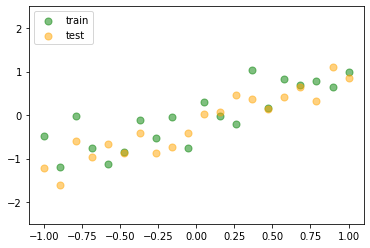

In [7]:
# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='green', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='orange', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

#### Exercise

Create a network `net_simple` as `nn.Sequential` with the following structure: `Fully Connected N_HIDDEN -> ReLU -> Fully Connected N_HIDDEN -> ReLU -> Fully Connected 1`

In [8]:
net_simple = torch.nn.Sequential(
#     TODO
  torch.nn.Linear(1, N_HIDDEN),
  torch.nn.ReLU(),
  torch.nn.Linear(N_HIDDEN, N_HIDDEN),
  torch.nn.ReLU(),
  torch.nn.Linear(N_HIDDEN, 1)
)

print(net_simple)

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)


#### Exercise

Now define the same architecture with `Dropout` layers in-between with $p=0.5$. Where will you place them?

In [9]:
net_dropout = torch.nn.Sequential(
#    TODO
  torch.nn.Linear(1, N_HIDDEN),
  torch.nn.ReLU(),
  torch.nn.Dropout(),
  torch.nn.Linear(N_HIDDEN, N_HIDDEN),
  torch.nn.ReLU(),
  torch.nn.Dropout(),
  torch.nn.Linear(N_HIDDEN, 1)
)

print(net_dropout)

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=300, out_features=1, bias=True)
)


In [10]:
optimizer_simple = torch.optim.Adam(net_simple.parameters(), lr=0.01)
optimizer_dropout = torch.optim.Adam(net_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

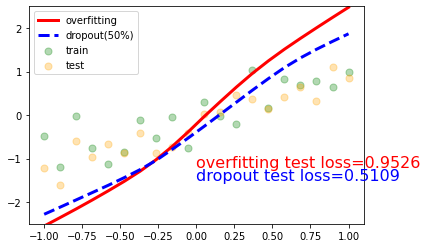

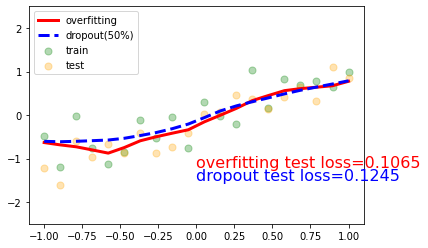

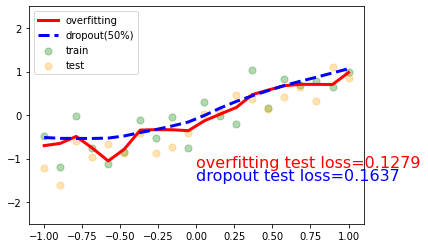

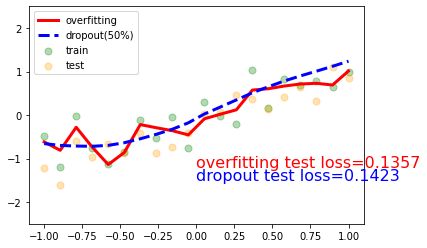

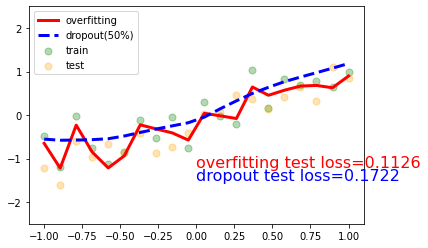

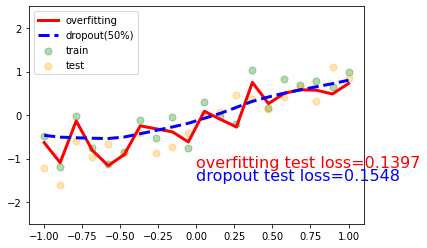

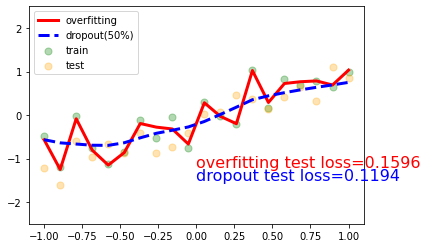

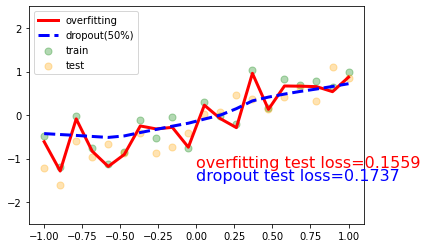

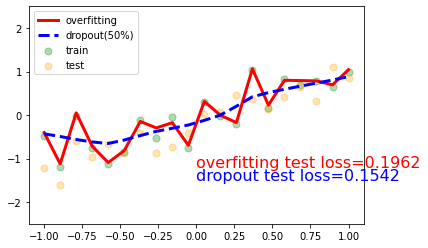

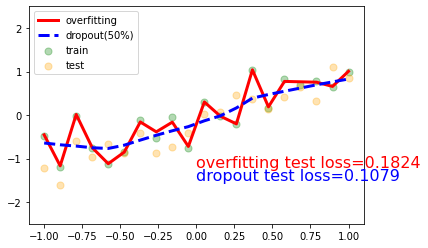

In [11]:
for epoch in range(1000):
    pred_simple = net_simple(x)
    pred_drop = net_dropout(x)
    loss_simple = loss_fn(pred_simple, y)
    loss_dropout = loss_fn(pred_drop, y)

    optimizer_simple.zero_grad()
    optimizer_dropout.zero_grad()
    loss_simple.backward()
    loss_dropout.backward()
    optimizer_simple.step()
    optimizer_dropout.step()

    if epoch % 100 == 0:
        # change to eval mode in order to fix drop out effect
        net_simple.eval()
        net_dropout.eval()  # parameters for dropout differ from train mode

        # plotting
        plt.cla()
        test_pred_simple = net_simple(test_x)
        test_pred_dropout = net_dropout(test_x)
        plt.scatter(x.data.numpy(), y.data.numpy(), c='green', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='orange', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_simple.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        plt.text(0, -1.2, 'overfitting test loss=%.4f' % loss_fn(test_pred_simple, test_y).data.item(), fontdict={'size': 16, 'color':  'red'})
        plt.text(0, -1.5, 'dropout test loss=%.4f' % loss_fn(test_pred_dropout, test_y).data.item(), fontdict={'size': 16, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5));plt.pause(0.1)

        # change back to train mode
        net_simple.train()
        net_dropout.train()
        plt.show()